In [20]:
import numpy as np
import pandas as pd

from __future__ import print_function, division

import requests

import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import re # for regex; e.g. text=re.compile('inserttexthere')

from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split # randomly creates test sets
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
# load pickle file
with open('data/my_data_2_updated.pkl','rb') as picklefile:
    df_updated_2 = pickle.load(picklefile)

In [4]:
df_updated_2.columns

Index(['release_date', 'manufacturer', 'chipset', 'dual_gpu', 'passmark_score',
       'gpuboss_score', 't_rex_gfx_score', 'manhattan_gfx_score', 'market',
       'clock_speed_MHz', 'turbo_clock_speed_MHz', 'shading_units',
       'texture_mapping_units', 'render_output_processors',
       'pixel_rate_GPixel/s', 'texture_rate_GTexel/s',
       'floating_point_performance_GFLOPS', 'memory_clock_speed',
       'effective_memory_clock_speed_MHz', 'memory_bus_bit', 'memory_MB',
       'memory_type', 'memory_bandwidth_GB/s', 'tdp_W', 'AMD', 'ASUS', 'ATi',
       'BIOSTAR', 'Colorful', 'Diamond', 'EVGA', 'GIGABYTE', 'Generic', 'HIS',
       'Leadtek', 'MSI', 'Nvidia', 'PowerColor', 'SPARKLE', 'Sapphire', 'XFX',
       'ZOTAC', 'no_dual_gpu', 'yes_dual_gpu', 'desktop_market',
       'laptop_market', 'undefined_market', 'DDR2_memory', 'DDR3_memory',
       'GDDR3_memory', 'GDDR5_memory', 'undefined_memory'],
      dtype='object')

# visualization with seaborn

In [5]:
len(df_updated_2['gpuboss_score'].dropna()) # number of GPUs with gpuboss ratings

267

In [6]:
# number of GPUs with high rating, out of 267 GPUs with a valid gpuboss score
len(df_updated_2.loc[df_updated_2['gpuboss_score']>8.0]) 

11

Saving graph to: images/review_hist.svg


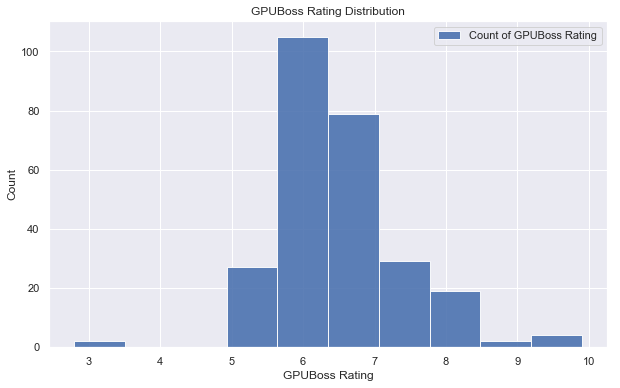

In [7]:
# histogram of video card ratings from gpuboss - only 11 video cards have a rating > 8.0
sns.set()
plt.figure(figsize=(10,6))
plt.hist(df_updated_2['gpuboss_score'].dropna(), alpha=0.9,label='Count of GPUBoss Rating')
plt.title('GPUBoss Rating Distribution')
plt.xlabel('GPUBoss Rating')
plt.ylabel('Count')
plt.legend();

# Save options
save = 'images/review_hist'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

### Move column 'gpuboss_score to the front of the DataFrame; new DataFrame: df_updated_3

In [8]:
df_updated_3 = df_updated_2[['gpuboss_score'] + [c for c in df_updated_2 if c not in ['gpuboss_score']]]

In [9]:
df_updated_3.head(3) # head of data

,gpuboss_score,release_date,manufacturer,chipset,dual_gpu,passmark_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
0,NaN,2008-01-01,ATi,Radeon X1050,No,49.0,NaN,NaN,Desktop,400,...,1,0,1,0,0,0,0,0,0,1
1,NaN,2008-01-01,ATi,Mobility Radeon HD 3650,No,216.0,1704.69,NaN,Laptop,500,...,1,0,0,1,0,0,0,1,0,0
2,NaN,2008-01-01,Nvidia,GeForce 8800 GS,No,551.0,NaN,NaN,Desktop,550,...,1,0,1,0,0,0,0,1,0,0


### develop a DataFrame with only rows that have gpuboss rating

In [16]:
df_train = df_updated_3.loc[df_updated_3['gpuboss_score'].notnull()]

In [17]:
df_train.head(3)

,gpuboss_score,release_date,manufacturer,chipset,dual_gpu,passmark_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
12,6.2,2008-02-01,Nvidia,GeForce GT 9600,No,739.0,NaN,NaN,Desktop,650,...,1,0,1,0,0,0,1,0,0,0
29,6.4,2008-06-01,ATi,Radeon HD 4850,No,1028.0,3357.10,NaN,Desktop,625,...,1,0,1,0,0,0,0,1,0,0
31,6.2,2008-07-01,Nvidia,GeForce GT 9800,No,716.0,3307.06,NaN,Desktop,600,...,1,0,1,0,0,0,0,1,0,0


### Columns to drop (in order to fit data into linear regression / statsmodel):
- manufacturer
- chipset
- dual_gpu
- market
- memory_type

### Columns to drop (no correlation with gpuboss score):
- BIOSTAR
- HIS

In [18]:
# drop categorical features that have already been transformed to dummy variables
df_train = df_train.drop(['manufacturer','chipset','dual_gpu','market','memory_type'], axis = 1)

# drop features that are not correlated with gpuboss_score
df_train = df_train.drop(['BIOSTAR','HIS'], axis = 1)

### convert datetime values into numerical values

In [21]:
df_train['release_date']=df_train['release_date'].map(datetime.toordinal)

### We will use K-Nearest Neighbor (KNN) to handle missing data

In this method, k neighbors are chosen based on some distance measure and their average is used as an imputation estimate. The method requires the selection of the number of nearest neighbors, and a distance metric. KNN can predict both discrete attributes (the most frequent value among the k nearest neighbors) and continuous attributes (the mean among the k nearest neighbors)
The distance metric varies according to the type of data:
1. Continuous Data: The commonly used distance metrics for continuous data are Euclidean, Manhattan and Cosine
2. Categorical Data: Hamming distance is generally used in this case. It takes all the categorical attributes and for each, count one if the value is not the same between two points. The Hamming distance is then equal to the number of attributes for which the value was different.

In [ ]:
from fancyimpute import KNN    

# set df_train as numpy array for KNN
df_train_array = df_train.select_dtypes(include=[np.float,np.int]).as_matrix()

# Use 5 nearest rows which have a feature to fill in each row's missing features
df_train_filled = pd.DataFrame(KNN(k=5).fit_transform(df_train_array),columns=df_train.columns,index=df_train.index)

### reset the index

In [ ]:
df_train_filled = df_train_filled.reset_index(drop=True)

In [ ]:
df_train_filled.info()

### save KKN-filled DataFrame via Pickle

In [ ]:
# save updated DataFrame with Pickle - dump into new file
with open('data/df_train_filled.pkl','wb') as picklefile:
    pickle.dump(df_train_filled,picklefile)